In [18]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

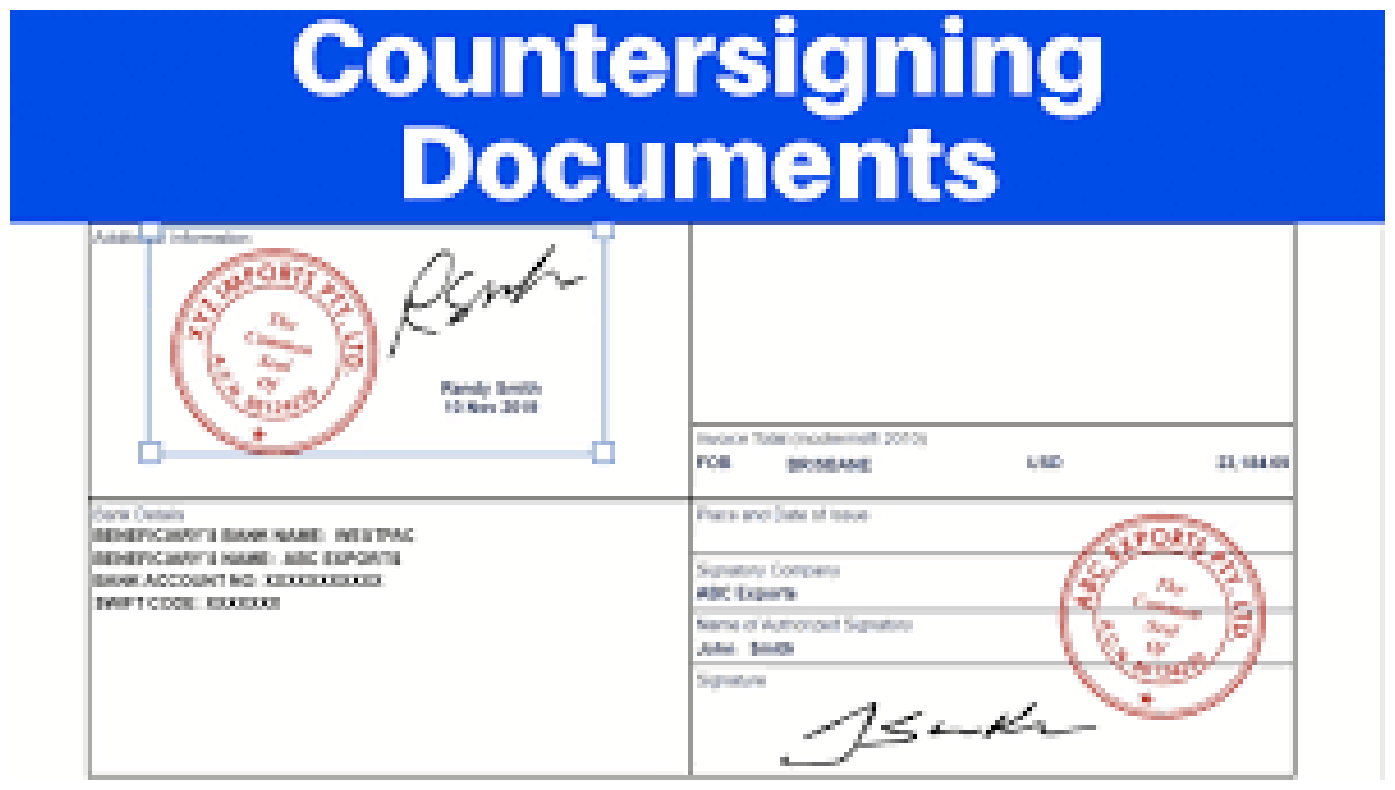

In [33]:
## Read and display the image

imgFile = "./images/download.png"
img = cv2.imread(imgFile)

def imshow(img, showAxis = False, size=(20,10)):
    plt.figure(figsize=size)
    if not showAxis: plt.axis('off')
    if len(img.shape) == 3: plt.imshow(img[:,:,::-1])
    else: plt.imshow(img, cmap='gray')
    
imshow(img)

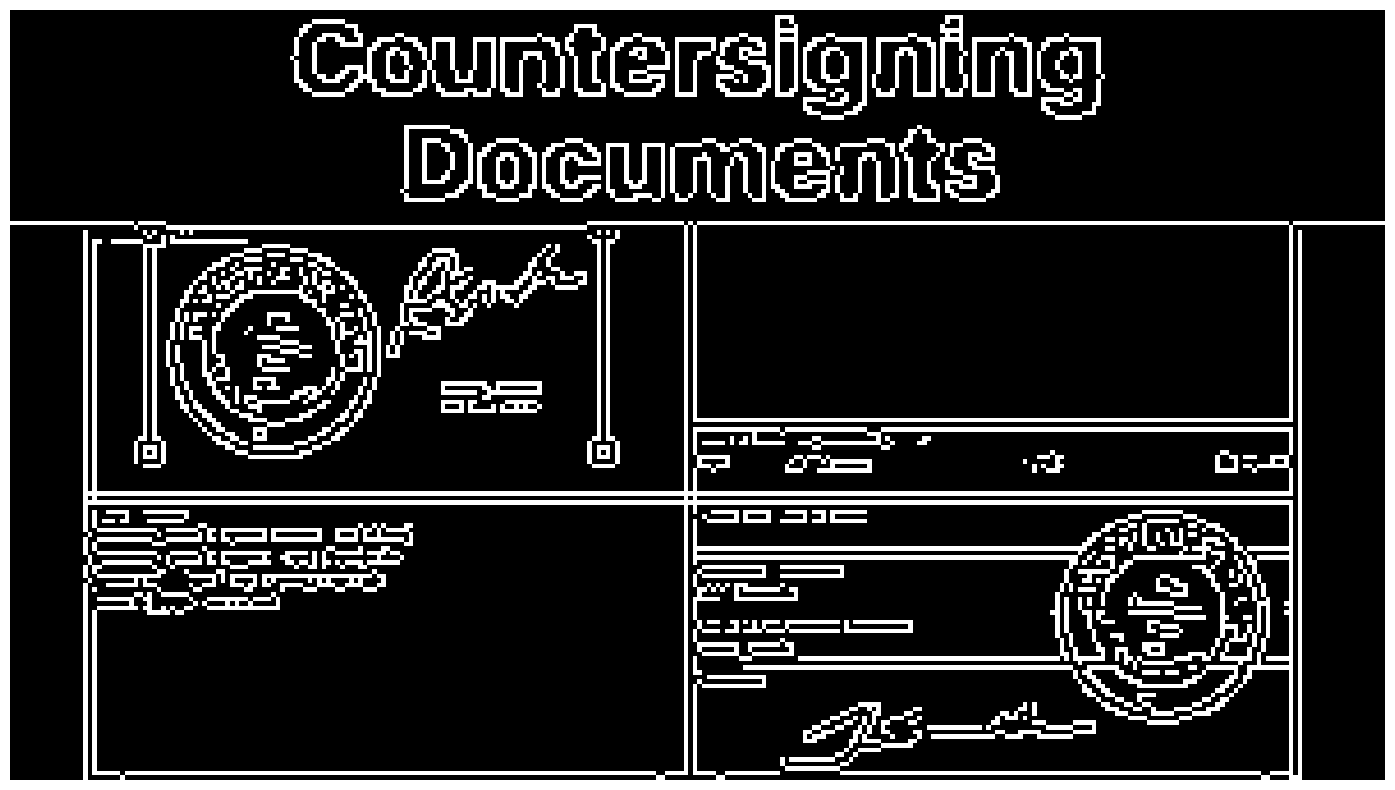

In [34]:
## Blur & detect the edges

# Convert to Grayscale
gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

# Blur to remove noise
blur = cv2.bilateralFilter(gray.copy(), 15, 15, 15 )

# Find edges using canny edge detector
def auto_canny(grayim, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(grayim)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(grayim, lower, upper)
    # return the edged image
    return edged

# Find the edges and display the image
edged = auto_canny(blur)
imshow(edged)

In [35]:
## Find Contours

# detect the contours on the binary image
contours, _ = cv2.findContours(image=edged.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
print(f'Total nr of contours found: {len(contours)}')

# Sort Contours by Area and get topN
topN = 10
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)                     
sorted_contours = sorted_contours[:topN]

Total nr of contours found: 83


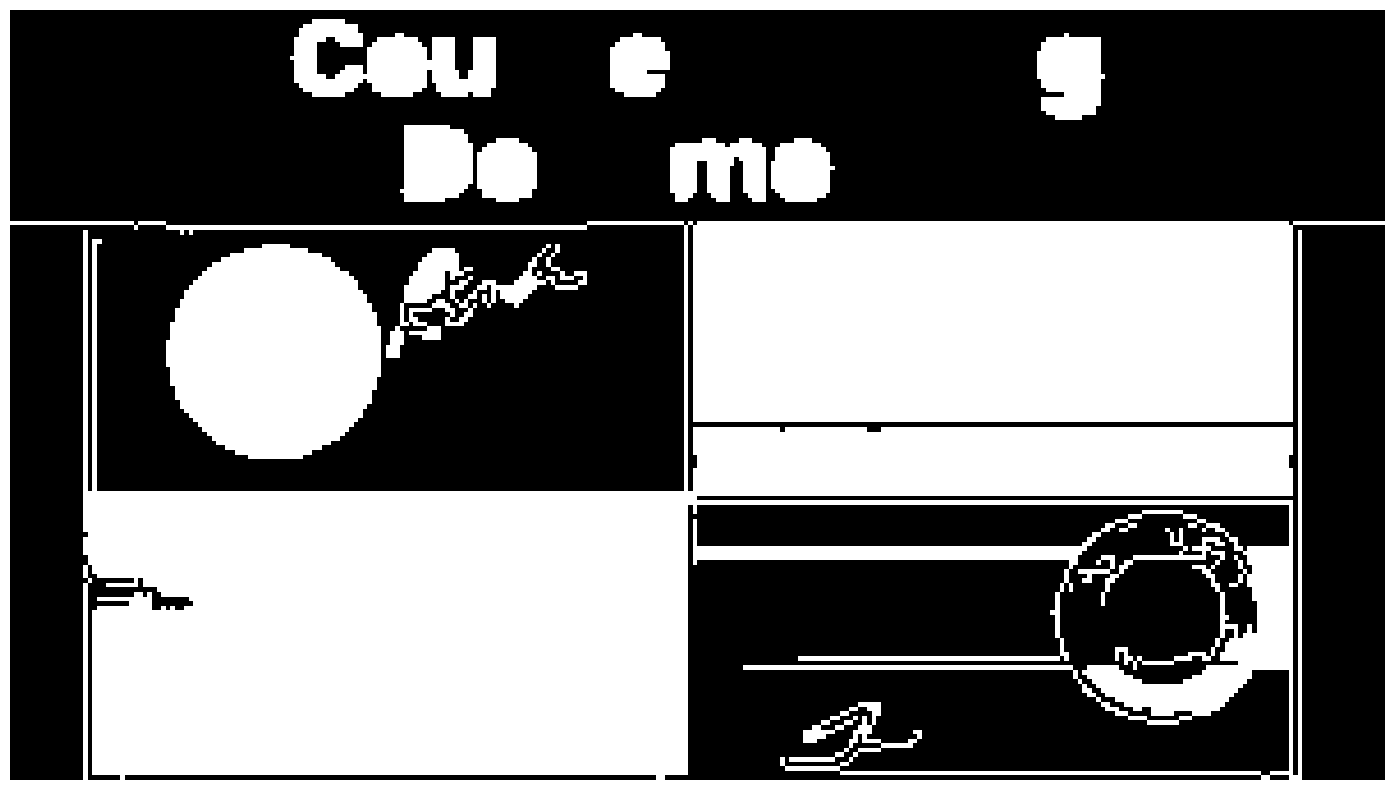

In [36]:
##  Fill the area inside contours
filteredCircle = np.zeros((img.shape[:2]), dtype =np.uint8)
cv2.drawContours(image=filteredCircle, contours=sorted_contours, contourIdx=-1, color=(255, 255, 255), thickness=cv2.FILLED)
imshow(filteredCircle)

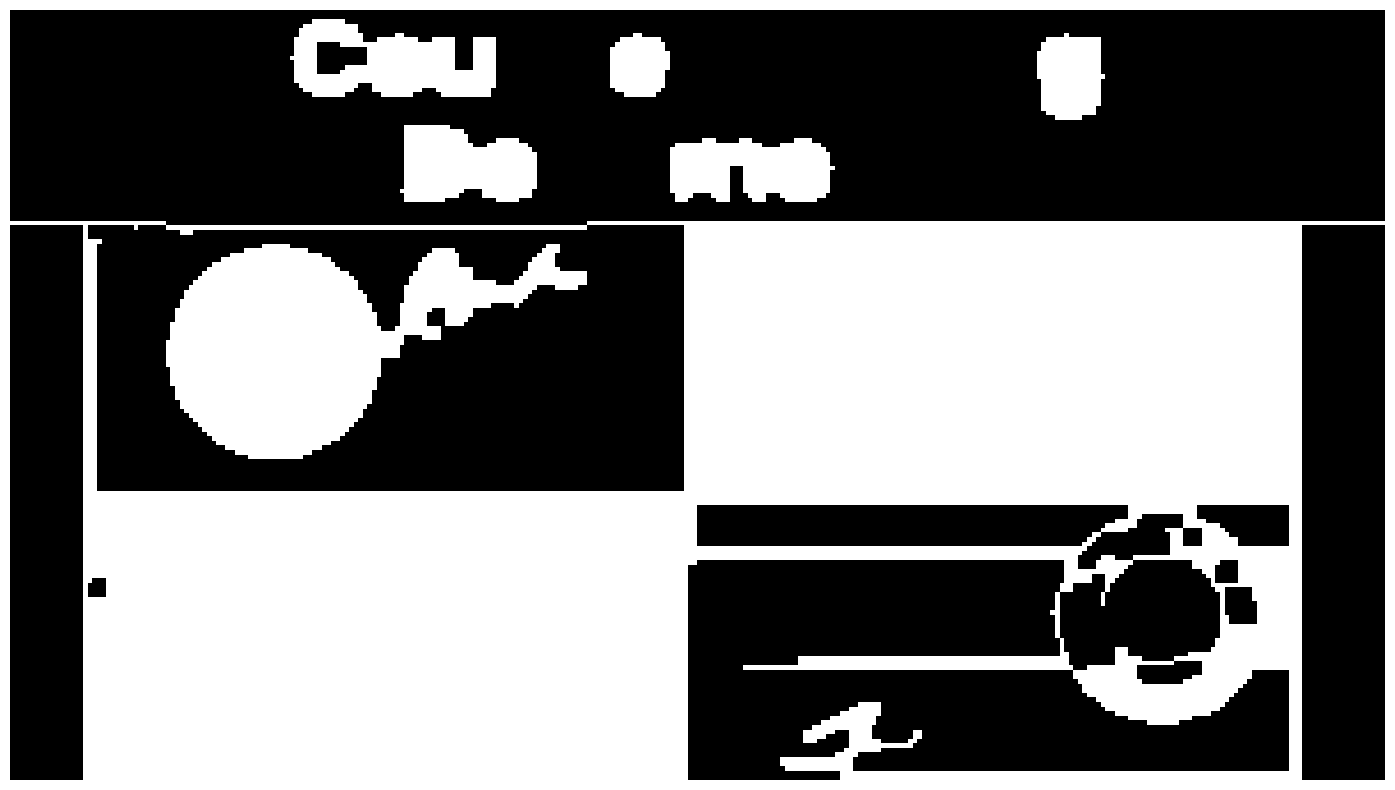

In [37]:
## Close Blobs

kernel = np.ones((3,3),np.uint8)
closedCircle = cv2.morphologyEx(filteredCircle, cv2.MORPH_CLOSE, kernel, iterations=1)
imshow(closedCircle)

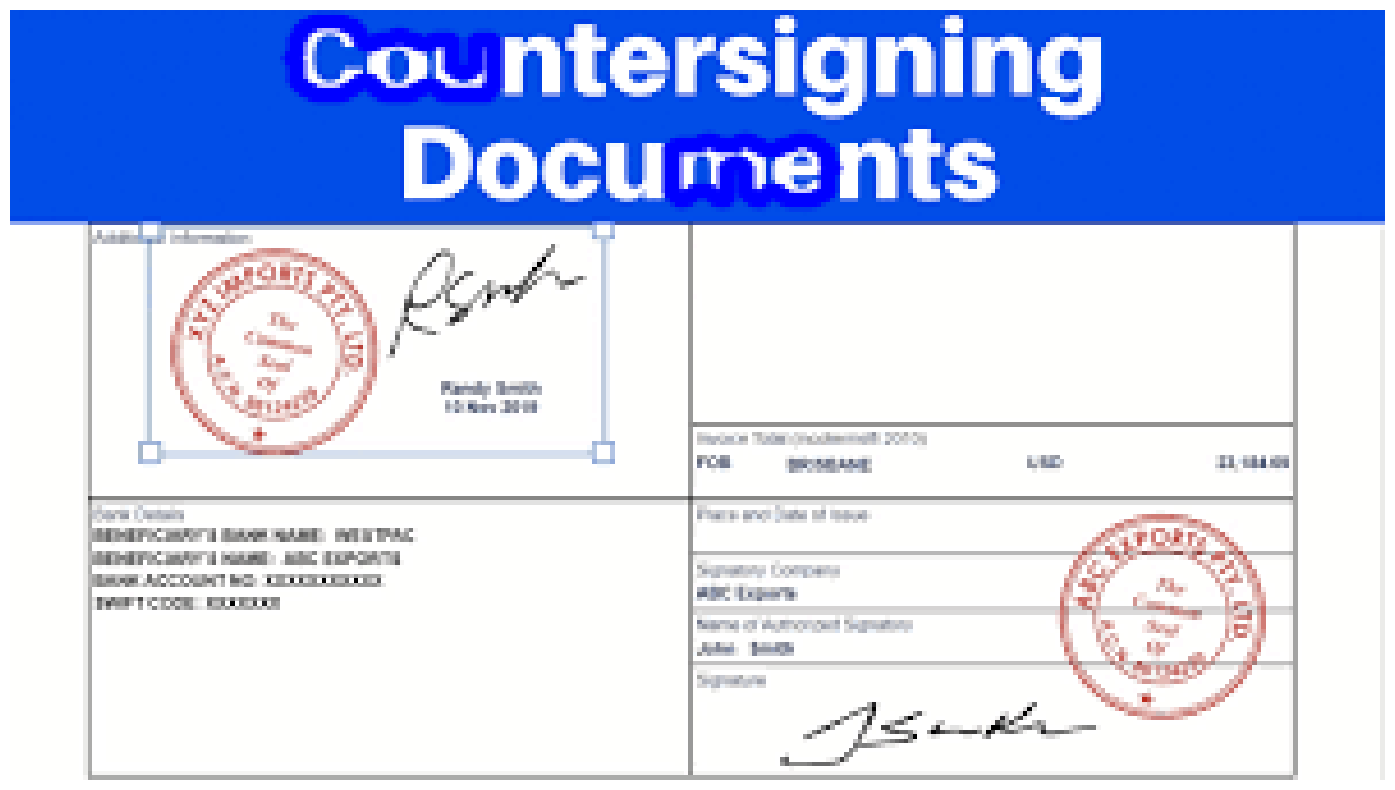

In [38]:
## Filter Stamps

# Find contours from the processed binary image
filteredContours, _ = cv2.findContours(image=closedCircle.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

# Identify only contours with more than 5 points
circleContours = []
for index, contour in enumerate(filteredContours):
    perimeter = cv2.arcLength(contour,True)
    approxPoints = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    if len(approxPoints) > 5: 
        circleContours.append(contour)

# Display the identified stamps
out = img.copy()
cv2.drawContours(image=out, contours=circleContours, contourIdx=-1, color=(255,0, 0), thickness=2, lineType=cv2.LINE_AA)
imshow(out)

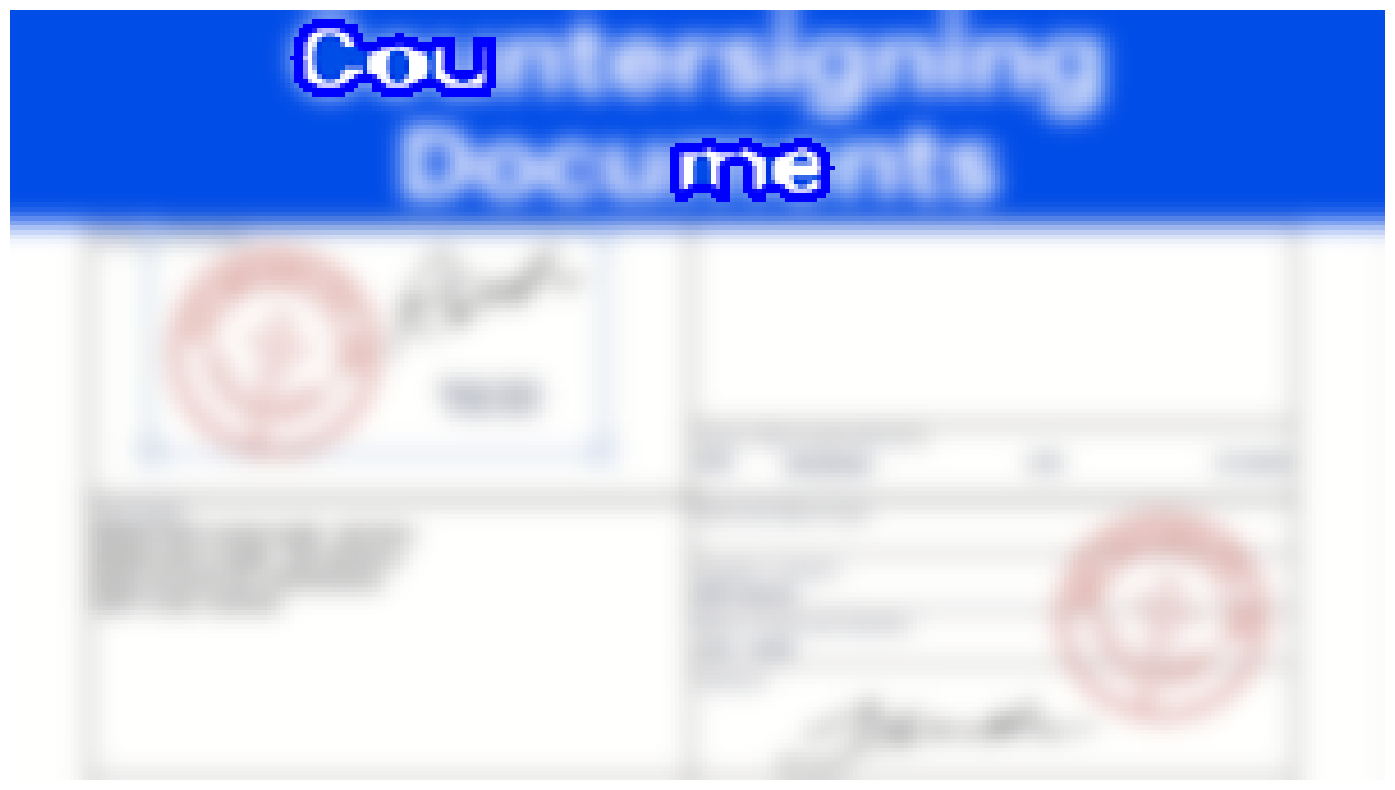

In [39]:
# Highlight the stamped region

# Import
from itertools import product

# Blur the image
highlight_blur = cv2.GaussianBlur(img.copy(), (15,15),0)

# Loop through every point in the image
for y, x in product(range(img.shape[0]), range(img.shape[1])):
    # Loop through all the contours
    for contour in circleContours:
        # Check if the point is on or inside the contour
        if cv2.pointPolygonTest(contour, [x, y], False) >= 0.0:
            # Replace the image with the output image
            highlight_blur[y, x, :] = out[y, x, :]

imshow(highlight_blur)